In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import accuracy, error_rate

from gzip import GzipFile

In [2]:
image_path = Path('../image-data/09-lr-disparity-combo-gray/')
image_path.ls()

[PosixPath('../image-data/09-lr-disparity-combo-gray/high'),
 PosixPath('../image-data/09-lr-disparity-combo-gray/medium'),
 PosixPath('../image-data/09-lr-disparity-combo-gray/models'),
 PosixPath('../image-data/09-lr-disparity-combo-gray/low')]

In [3]:
class ImageItemList_XChannel(ImageList):
    def open(self, fname):
        with GzipFile(fname, 'r') as in_file:
            np_image = np.load(in_file).astype(np.float32)/255        
        return Image(pil2tensor(np_image, np.float32).float())

In [4]:
image_size = 256
batch_size = 64
tfms = get_transforms()

In [5]:
data = (ImageItemList_XChannel.from_folder(image_path, extensions='.gz')
       .split_by_rand_pct()
       .label_from_folder()
       .transform(tfms, size=image_size)
       .databunch(bs=batch_size)
       .normalize()) # Optional

In [6]:
data

ImageDataBunch;

Train: LabelList (4709 items)
x: ImageItemList_XChannel
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
high,high,high,high,high
Path: ../image-data/09-lr-disparity-combo-gray;

Valid: LabelList (1177 items)
x: ImageItemList_XChannel
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
high,medium,high,high,high
Path: ../image-data/09-lr-disparity-combo-gray;

Test: None

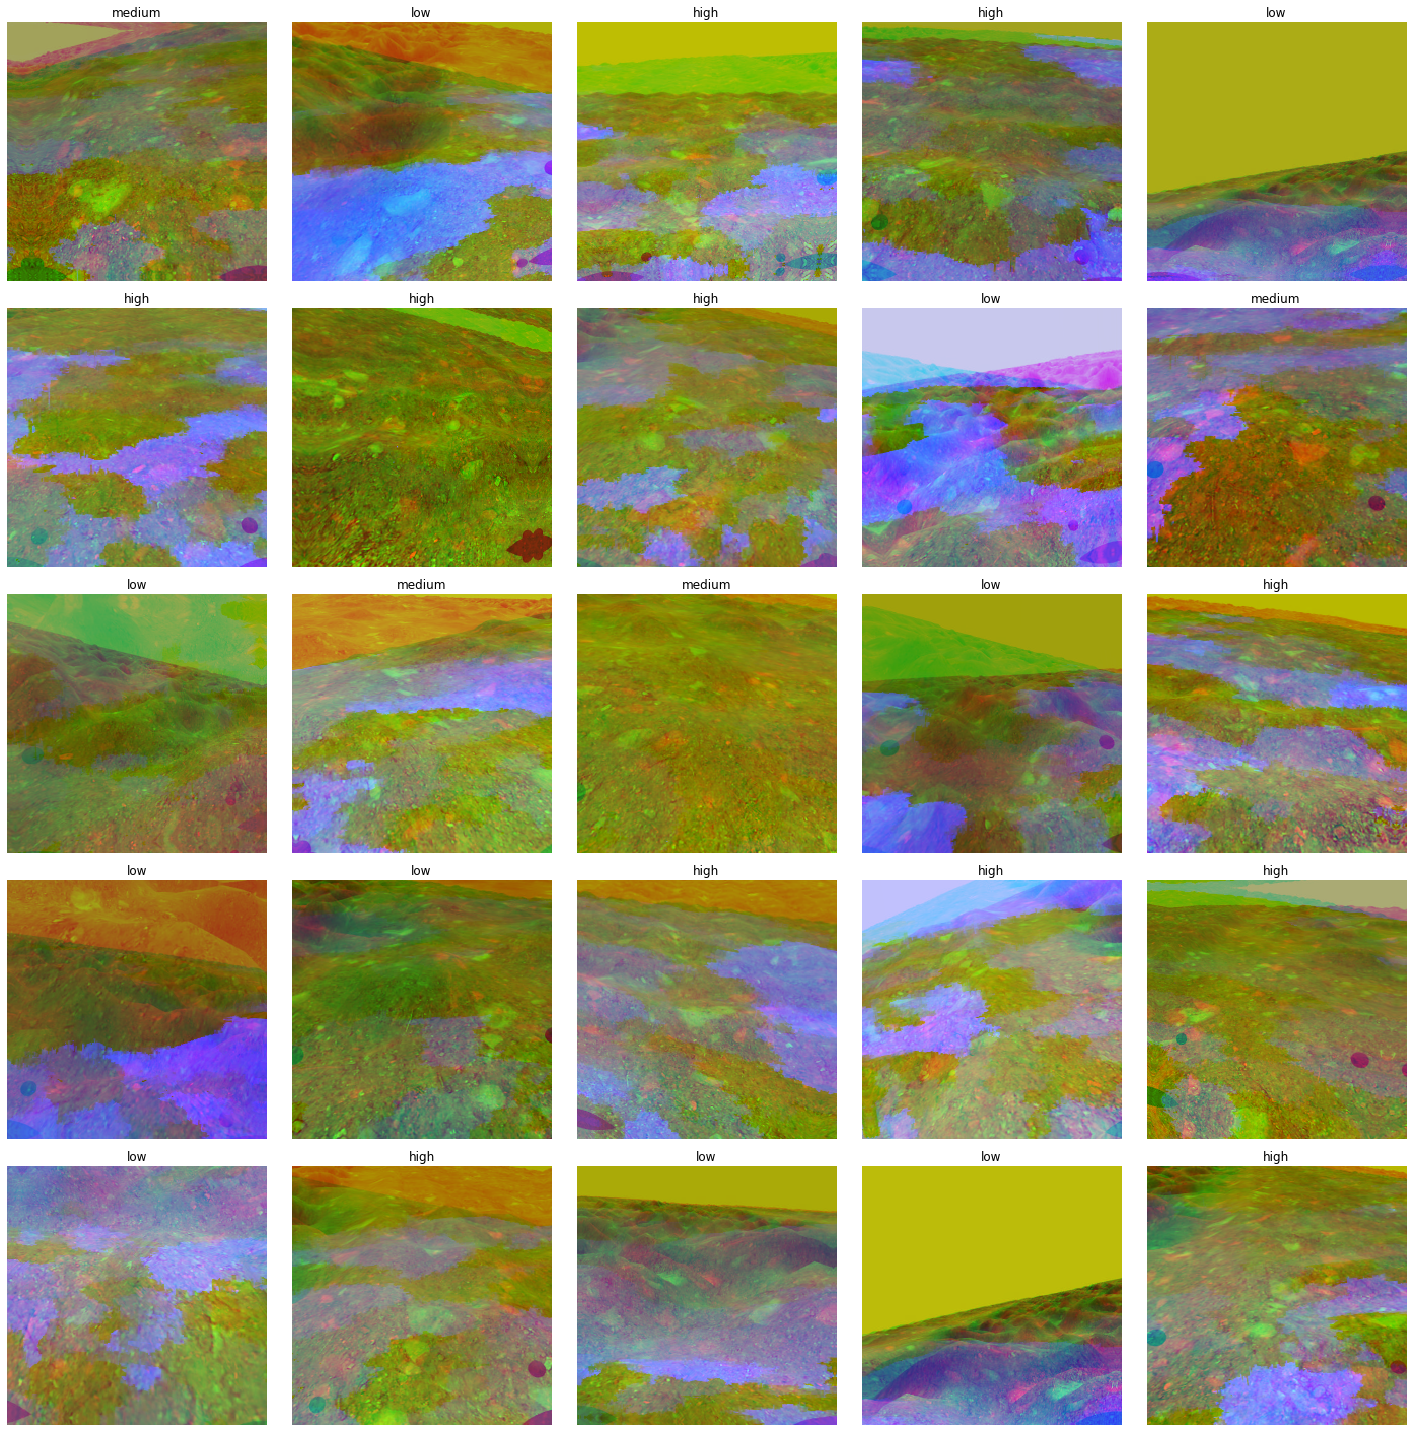

In [7]:
data.show_batch()

In [8]:
data.classes, data.c

(['high', 'low', 'medium'], 3)

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate], pretrained=False, callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.995205,0.698681,0.637213,0.362787,00:22
1,0.820544,0.565083,0.734919,0.265081,00:20
2,0.689765,0.499333,0.745964,0.254036,00:20
3,0.591643,0.411035,0.828377,0.171623,00:20
4,0.501736,0.346975,0.845370,0.154630,00:21
5,0.425939,0.255451,0.896347,0.103653,00:21
6,0.348656,0.212041,0.908241,0.091759,00:22
7,0.293260,0.179970,0.927782,0.072218,00:20
8,0.238168,0.144778,0.940527,0.059473,00:20
9,0.213385,0.138928,0.942226,0.057774,00:20


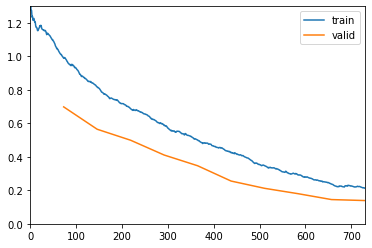

In [10]:
learn.fit_one_cycle(10)

In [11]:
learn.save('stage1-stacked-gray-disp')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

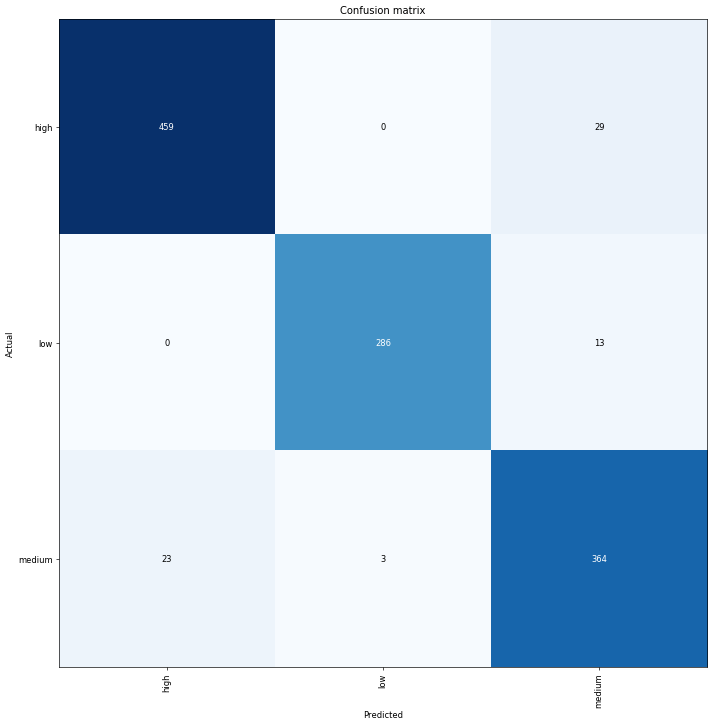

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.recorder.plot_losses()
x = plt.gca()
x.set_title('test')
plt.gcf().savefig('test.pdf')

In [14]:
from time import time

learn.load('stage1-stacked-gray-disp')
learn.model.training = False

grass_path = Path('../image-data/grass/9-gray-dsp')

grass_path.ls()

[PosixPath('../image-data/grass/9-gray-dsp/high'),
 PosixPath('../image-data/grass/9-gray-dsp/medium'),
 PosixPath('../image-data/grass/9-gray-dsp/low')]

In [15]:
# Doing this in a loop to get running times

def open_stacked(fname):
    with GzipFile(fname, 'r') as in_file:
        np_image = np.load(in_file).astype(np.float32)/255        
    return Image(pil2tensor(np_image, np.float32).float())

clsses = ['high', 'medium', 'low']
totals = [0, 0, 0]
correct = [0, 0, 0]

total_time = 0

for clss_idx, clss in enumerate(clsses):
    grass_fnames = grass_path/clss
    print(grass_fnames)
    for grass_fname in grass_fnames.glob('*.gz'):
        
        img = open_stacked(grass_fname)
        
        tstart = time()
        pred = learn.predict(img)
        total_time += time() - tstart
        
        if str(pred[0]) == clss:
            correct[clss_idx] += 1
        totals[clss_idx] += 1
print('done')

../image-data/grass/9-gray-dsp/high
../image-data/grass/9-gray-dsp/medium
../image-data/grass/9-gray-dsp/low
done


In [16]:
print(correct)
print(totals)
print([c/t*100 for c, t in zip(correct, totals)])
print(sum(correct)/sum(totals)*100)
print(total_time)

[237, 100, 177]
[284, 295, 295]
[83.45070422535211, 33.89830508474576, 60.0]
58.81006864988558
6.319637775421143
